# DATA DOWNLOAD
To start this project, you need an addition data file.

First you should download data from:
https://pan.baidu.com/s/1KFui9zZKjRqzFkCJH5nenw
    
Then unzip it,create a data dir, and put it in data directory

## After you do all that , the following file should be found:

```python
'data/segmented_train_seg_by_word.txt' 
```

And that means you are good to go.

In [66]:
# segmented_train_seg_by_word.txt 内容sample
# couple of what ? who ' s buddy ?
#一对 什么 ？ 哥们儿 是 谁 ？ 

! wc -l data/segmented_train_seg_by_word.txt

 20000000 data/segmented_train_seg_by_word.txt


# DATA PROCESS

In [1]:
from utils import ProgressBar
import numpy as np

In [2]:
enline = None
chline = None

sentlength = 5

enlines = []
chlines = []
pb = ProgressBar(worksum=10000000)
pb.startjob()
num = 0
# 中文， 英文 分类， 只留下长度 <=5的句子
with open('data/segmented_train_seg_by_word.txt') as fhdl:
    for line in fhdl:
        num += 1
        if num % 2 == 1:
            enline = line
            continue
        else:
            chline = line
        
        enlinesp = [i.lower() for i in enline.strip("\n").split()]
        # text_classify_basic  里chlinesp是split成每个单词，这里没有，而是split成每个字
        # chlinesp sample: ['一', '对', '五', '百', '诶', '。']
        chlinesp = [i for i in chline.strip("\n").replace(' ','')]
        if len(enlinesp) <= sentlength and len(chlinesp) <= sentlength:
            enlines.append(enlinesp)
            chlines.append(chlinesp)
        if (num // 2) % 1000 == 0:
            pb.complete(1000)
        

 100.00 % [==================================================>] 10000000/10000000 	 used:61s eta:0 s

In [31]:
enlines[:10]

[['deuces', 'the', 'winner', '.'],
 ['a', 'couple', 'of', 'what', '?'],
 ['a', 'pair', 'of', 'wives', '?'],
 ['husband', 'and', 'wife', '.'],
 ['couple', '.'],
 ['nice', 'couple', '.'],
 ['two', 'lovers', '.'],
 ['a', 'couple', 'getting', 'married', '.'],
 ['couple', 'of', 'newbies', '?'],
 ['a', 'couple', 'of', 'gunslingers', '.']]

In [32]:
#中文这里 用每个字 而不是单词
chlines[:10]

[['一', '对', '二', '胜', '。'],
 ['一', '对', '什', '么', '？'],
 ['一', '对', '太', '太', '？'],
 ['一', '对', '夫', '妇', '。'],
 ['一', '对', '夫', '妻', '。'],
 ['一', '对', '好', '人', '。'],
 ['一', '对', '情', '人', '。'],
 ['一', '对', '新', '人', '。'],
 ['一', '对', '新', '手', '？'],
 ['一', '对', '枪', '手', '。']]

In [33]:
len(chlines),len(enlines)

(103912, 103912)

In [34]:
enwords = []
chwords = []
for sent in enlines:
    for enword in sent:
        enwords.append(enword)
        
for sent in chlines:
    for chword in sent:
        chwords.append(chword)
    

In [35]:
from collections import Counter

In [36]:
Counter(enwords).most_common(10)

[('.', 49461),
 ('?', 14511),
 ('the', 10472),
 ('i', 10013),
 (',', 9489),
 ('!', 8807),
 ('you', 7493),
 ('a', 6860),
 ("'", 5555),
 ('it', 5524)]

In [37]:
Counter(chwords).most_common(10)

[('。', 44900),
 ('我', 15087),
 ('？', 14454),
 ('你', 9087),
 ('！', 8915),
 ('了', 8663),
 ('的', 8053),
 ('，', 7291),
 ('一', 6091),
 ('是', 5946)]

In [43]:
len(set(enwords)),len(set(chwords))

(21739, 4054)

In [44]:
ch2ind = {}
ind2ch = {}
en2ind = {}
ind2en = {}

In [45]:
specialchars = ['<eos>','<start>','<end>','<unk>']

In [46]:
def addchar(what2ind,ind2what,char):
    if char in what2ind:
        return 
    ind2what[len(what2ind)] = char
    what2ind[char] = len(what2ind)

In [47]:
for one in specialchars:
    addchar(ch2ind,ind2ch,one)
    addchar(en2ind,ind2en,one)
print(ch2ind)
print(ind2ch)

{'<eos>': 0, '<start>': 1, '<end>': 2, '<unk>': 3}
{0: '<eos>', 1: '<start>', 2: '<end>', 3: '<unk>'}


In [48]:
# 只对 enwords 和 chwords 出现频率最高的前10000单词 构建 <word, index> <index, word>映射 词典
for word,_ in Counter(enwords).most_common(10000):
    addchar(en2ind,ind2en,word)

In [49]:
for word,_ in Counter(chwords).most_common(10000):
    addchar(ch2ind,ind2ch,word)

In [50]:
len(en2ind),len(ch2ind)

(10004, 4058)

### ？？？对应PPT 第七页“seq2seq 机器器翻译训练”图中右半边decoder图中的y in , y out 难道都是target y1, target y2

In [53]:
dat_x_in = []
# dat_y_in， dat_y_out 对应PPT 第七页“seq2seq 机器器翻译训练”图中右半边decoder图中的y in , y out （target y1）
dat_y_in = []
dat_y_out = []

dat_x_len = []
dat_y_len = []

# ensent 每一句英语句子
for ensent in enlines:
    # 对英语句子里,每个单词, 取出其在词典里对应的index, 然后放入 indsent. indsent里面都是数字index
    indsent = [en2ind.get(i,en2ind['<unk>']) for i in ensent]
    indsent.append(en2ind['<eos>'])
    # 以句子为单位，将当前句子里每个词装换成index 结果加上eos特殊符号的index(i.e. 0)，放入dat_x_in数组
    # 数组dat_x_in 里每一个元素大概这样： [3, 6, 2730, 4, 0]
    dat_x_in.append(indsent)
    dat_x_len.append(len(indsent))
    
for chsent in chlines:
    indsent = [ch2ind.get(i,ch2ind['<unk>']) for i in chsent]
    #indsent.append(ch2ind['<eos>'])
    # dat_y_in里每个元素大概这样： [1, 12, 63, 582, 901, 4] 1 就是start的index
    dat_y_in.append([ch2ind['<start>']] + indsent)
    # dat_y_out里每个元素大概这样： [12, 63, 582, 901, 4, 2] 2 就是end的index
    dat_y_out.append(indsent + [ch2ind['<end>']])
    # 相比较 dat_x_len 里 每个句子结尾只加了一个eos特殊符号，这里每个句子前后各加了start end
    dat_y_len.append(len(indsent) + 1)

In [61]:
[ind2en[i] for i in dat_x_in[4]]

['couple', '.', '<eos>']

In [62]:
[ind2ch[i] for i in dat_y_in[4]]

['<start>', '一', '对', '夫', '妻', '。']

In [253]:
[ind2ch[i] for i in dat_y_out[4]]

['一', '对', '夫', '妻', '。', '<end>']

In [63]:
dat_x_len[4],dat_y_len[4]

(3, 6)

In [65]:
len(dat_x_in),\
len(dat_y_in),\
len(dat_y_out),\
len(dat_x_len),\
len(dat_y_len)

(103912, 103912, 103912, 103912, 103912)

# MODEL PART

In [158]:
from tensorflow.python.layers import core as layers_core

In [150]:
import tensorflow as tf
import tflearn
tf.reset_default_graph()
config = tf.ConfigProto(log_device_placement=True,allow_soft_placement = True)
config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = tf.Session(config=config)


In [315]:
#相当于把每个单词对应成512维的向量
embedding_size = 512
# RNN->S1->RNN->S2...这里的512就是就是S1的大小，也就是hidden unit memory 的大小
# 512个float -> 512 * 32 bit 512 * 4字节
#？？？ LSTM 中 最后输出 的那些分支
# 老师解释：在LSTM里就是 相当于Ct(长期记忆)和Ht（短期记忆）都是num_unit个浮点数， 也就是memory size
#在标准的RNN里就是是S1, S2 等这些转态的memeory size. 
num_units = 512
# 
batch_size = 128
#这里代码里用了1层的双向RNN，所以layer 是2。 对应课件PPT Week12.Session1.RNN-NMT.pdf第20页双向RNN图比较好理解
layer_number = 2
# ？？？梯度裁剪 PPT里有提到， 是对应哪个变量 是裁剪阀值c吗？
max_grad = 1.0
dropout = 0.2
# 英语 翻译成 中文，这里是输入 英语词汇表的大小
src_vocab_size = len(en2ind)
# 英语 翻译成 中文，这里是输出 中文词汇表的大小
target_vocat_size = len(ch2ind)
# sentlength 上面定义过了是5
seq_max_len = sentlength + 1
# 老师课上提到是解码的时候最长可以输出多长，对应课件PPT Week12.Session1.RNN-NMT.pdf 7页 seq2seq 机器翻译训练
# 右上角的<end> end 是一种结束解码的方式，这里也可以用maximum_iterations, 代码里已经用了<end>，这里这个变量可以防止句子过长,也就是解码序列超过这个值，后面的就不处理了
maximum_iterations = 10

In [301]:

tf.reset_default_graph()
config = tf.ConfigProto(log_device_placement=True,allow_soft_placement = True)
config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = tf.Session(config=config)

with tf.device('/gpu:1'):
    # all of the LSTM's parameters with the uniform distribution between -0.08 and 0.08
    initializer = tf.random_uniform_initializer(-0.08, 0.08)
    tf.get_variable_scope().set_initializer(initializer)
    
    # ？？？dat_x_in 是二维的，batch_size, time_step (每个词) batch_size 就是多少句话，time_step就是多少个每句话里多少单词？
    x = tf.placeholder("int32", [None, None])
    # dat_y_out 二维的
    y = tf.placeholder("int32", [None, None])
    # dat_y_in 二维的
    y_in = tf.placeholder("int32",[None,None])
    
    x_len = tf.placeholder("int32",[None])
    y_len = tf.placeholder("int32",[None])
    learning_rate = tf.placeholder(tf.float32, shape=[])
    
    # 对应PPT中图 比较好理解
    # embedding
    embedding_encoder = tf.get_variable(
        "embedding_encoder", [src_vocab_size, embedding_size],dtype=tf.float32)
    embedding_decoder = tf.get_variable(
        "embedding_decoder", [target_vocat_size, embedding_size],dtype=tf.float32)

    # 对应图左半边里面把X映射成embedding后的编码向量
    encoder_emb_inp = tf.nn.embedding_lookup(
        embedding_encoder, x)
     # 对应图右半边里面把y映射成embedding后的编码向量
     # ？？？ y_in 对应PPT page 7 里面右半边图的最下方的输入，在training 的时候有输入，不过在predict的时候没有输入
    decoder_emb_inp = tf.nn.embedding_lookup(
        embedding_decoder, y_in)
    
    # ？？？encoder ...这个项目里没有用到，PPT 附录里GNMT 论文里有用到
    num_bi_layers = int(layer_number / 2)
    
    # Build RNN cell
    encoder_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units)

    # Run Dynamic RNN 左半边的RNN
    #   encoder_outputs: [max_time, batch_size, num_units]
    #   encoder_state: [batch_size, num_units]
    # batch_size就是每个句子， time_step: 就是每个词
    # 譬如两句话  我吃米。 米好吃。 可以把两句话第一个词 （我， 米）同时送进去RNN训练
    # 左半边的训练
    encoder_outputs, encoder_state = tf.nn.dynamic_rnn(
        encoder_cell, encoder_emb_inp,
        sequence_length=x_len, time_major=False,dtype=tf.float32)
        
    
    # ???多少个setences?
    batch_size_in = tf.shape(x)[0]
    # 事先声明的dense 也就是fully connected layer， PPT 有半边图中紫色全连接的框
    # projection_layer 也就是FC层的输出 PPT中紫红色的框
    projection_layer = layers_core.Dense(
        len(ch2ind), use_bias=False)
    # Dynamic decoding
    with tf.variable_scope("decode_layer"):
        # Build RNN cell
        decoder_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units)
        # Helper 用来接收PPT page 7, 有半边图中的y_in 
        helper = tf.contrib.seq2seq.TrainingHelper(
            decoder_emb_inp, y_len, time_major=False)
        # Decoder
        decoder = tf.contrib.seq2seq.BasicDecoder(
            decoder_cell, helper, encoder_state,
            output_layer=projection_layer)
        # Dynamic decoding(training  阶段的 decode)
        outputs, _ , __ = tf.contrib.seq2seq.dynamic_decode(decoder)
        # 对应PPT 中softmax页面， RNN 每个时间片都输出logits
        # RNN 在training 阶段 的每个时间片（time_step）都会输出logits， logits 也就是  预测的值
        logits = outputs.rnn_output
        # seq_max_len 对应PPT 15页中，batch里每个sequence的max length
        #  tf.sequence_mask 函数就可以帮你生成PPT page 16里的mask
        # target_weights就是PPT中提到的mask矩阵
        target_weights = tf.sequence_mask(
            y_len, seq_max_len, dtype=logits.dtype)
    
    # predicting
    # Helper  训练 预测 共享网络参数
    # ？？?variable_scope reuse=True  就可以在predicting 阶段共享training参数
    with tf.variable_scope("decode_layer", reuse=True):
        # Helper
        helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(
            embedding_decoder,
            tf.fill([batch_size_in], ch2ind['<start>']), ch2ind['<end>'])

        # Decoder
        decoder = tf.contrib.seq2seq.BasicDecoder(
            decoder_cell, helper, encoder_state,
            output_layer=projection_layer)
        # Dynamic decoding
        outputs, _ , __= tf.contrib.seq2seq.dynamic_decode(
            decoder, maximum_iterations=maximum_iterations)
        translations = outputs.sample_id
        

    # calculate loss
    # sparse_softmax 可以加速运算
    # 基于PPT16 页， 去计算training 阶段的loss， 是基于训练时候每个时间片(time_step)输出的logits计算的
    crossent = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    # 上面也就是那预测的值logits 和lable y去计算sparse_softmax_cross_entropy
    #???分母中是一个batch里多少句话？？batch_size_in 为什么要除以这个？
    # 论文里也有说呀，是把梯度除了batch_size等效于loss除batch_size
    train_loss = (tf.reduce_sum(crossent * target_weights) / tf.cast(batch_size_in,tf.float32))
    
    optimizer_ori = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    trainable_params = tf.trainable_variables()
    gradients = tf.gradients(train_loss, trainable_params)
    # clip 就是梯度裁剪
    clip_gradients, _ = tf.clip_by_global_norm(gradients, max_grad)
    global_step = tf.Variable(0, trainable=False, name='global_step')
    optimizer = optimizer_ori.apply_gradients(
            zip(clip_gradients, trainable_params), global_step=global_step)
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(train_loss)
    #trainop = tflearn.TrainOp(loss=train_loss, optimizer=optimizer,
    #                          metric=train_loss, batch_size=64)

In [340]:
session.run(tf.global_variables_initializer())

In [303]:
session.run(encoder_emb_inp,feed_dict={
    x:np.asarray(dat_x_in[:1])
}).shape

(1, 6, 512)

In [256]:
dat_x_in = tf.keras.preprocessing.sequence.pad_sequences(dat_x_in,padding='post',value=en2ind['<eos>'])
dat_y_in = tf.keras.preprocessing.sequence.pad_sequences(dat_y_in,padding='post',value=en2ind['<end>'])
dat_y_out = tf.keras.preprocessing.sequence.pad_sequences(dat_y_out,padding='post',value=en2ind['<end>'])

dat_x_len = np.asarray(dat_x_len)
dat_y_len = np.asarray(dat_y_len)

In [304]:
dat_x_in.shape,dat_y_in.shape,dat_y_out.shape,dat_x_len.shape,dat_y_len.shape

((103912, 6), (103912, 6), (103912, 6), (103912,), (103912,))

In [341]:
losses = []
beginning_lr = 4
for one_epoch in range(0,40):
    index = np.asarray(list(range(len(dat_x_in))))
    np.random.shuffle(index)
    pb = ProgressBar(worksum=len(index))
    pb.startjob()
    for i in range(0,len(index),batch_size):
        # 在分类的例子里有个data_generate去数据，这里就hard_code取数据
        batchindex = index[i:i + batch_size]
        
        batch_lr = beginning_lr if one_epoch < 20 else beginning_lr * 0.5 ** (one_epoch - 20)
        if len(batchindex) < batch_size:
            break
        # 如果想看一下soft mask长什么样子可以 t = session.run(target_weights,feed_dict is same)
        _,batch_loss = session.run([optimizer,train_loss],feed_dict={
            x:dat_x_in[batchindex],
            y:dat_y_out[batchindex],
            y_in:dat_y_in[batchindex],

            x_len:dat_x_len[batchindex],
            y_len:dat_y_len[batchindex],
            learning_rate:batch_lr,
        })
        pb.info = "EPOCH {} batch {} lr {} loss {}".format(one_epoch + 1,i // batch_size,batch_lr,batch_loss)
        pb.complete(batch_size)
        losses.append(batch_loss)

EPOCH 40 batch 810 lr 7.62939453125e-06 loss 0.38680240511894226 99.90 % [=================================================>-] 103808/103912 	 used:17s eta:0 s

In [342]:
import pandas as pd

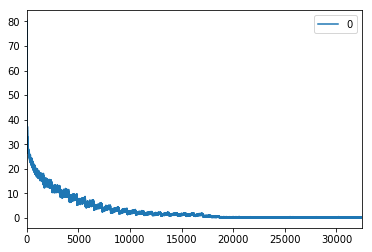

In [343]:
%matplotlib inline
pd.DataFrame(losses).plot()

# run predict

In [363]:
def translate(sent):
    senttoken = [en2ind[i.lower()] for i in sent.split()]
    senttoken.append(en2ind['<eos>'])
    inputx = np.asarray([senttoken])
    inputx_len = np.asarray([len(senttoken)])
    print(inputx,inputx_len)
    batch_translations = session.run(translations,feed_dict={
            x:inputx,
            x_len:inputx_len,
        })[0]
    return ''.join([ind2ch[i] for i in batch_translations])

In [426]:
source_sentence = "i love shopping ."

In [427]:
translate(source_sentence)

[[   7   84 1249    4    0]] [5]


'我爱购物。<end>'

In [430]:
! mkdir models

In [431]:
saver = tf.train.Saver()

In [433]:
saver.save(session,'models/seq2seq_model')

'models/seq2seq_model'

In [436]:
! ls -l 'models/seq2seq_model.data-00000-of-00001'

-rw-rw-r-- 1 meta meta 53903364  7月  5 20:45 models/seq2seq_model.data-00000-of-00001
